scrapy : 웹크롤링 FrameWork  
flask : 웹어플리케이션 FrameWork  

-> 목적이 다른 FrameWork이다~~

## playnomore
- http://playnomore.co.kr/
- scrapy에서 fake-useragent 사용
- scrapy를 실행할때 아규먼트를 설정해서 실행
- pipelines에서 데이터베이스로 데이터를 저장

In [1]:
import scrapy
import requests
from scrapy.http import TextResponse   # xpath찾을때 사용~

### 1. 프로젝트 생성

In [2]:
!rm -rf playnomore    #이미 생성되어있는거 다시 실행되는거 귀찮을때 -> 있던 디렉토리를 삭제하고 다시 생성!
!scrapy startproject playnomore

New Scrapy project 'playnomore', using template directory '/home/ubuntu/.pyenv/versions/3.6.9/envs/python3/lib/python3.6/site-packages/scrapy/templates/project', created in:
    /home/ubuntu/02.Crawling/06.scrapy/playnomore

You can start your first spider with:
    cd playnomore
    scrapy genspider example example.com


### 2. items.py  수정
- title, price, img, link

%load playnomore/playnomore/items.py

-> 아래의 내용이 불러와진다

In [3]:
# %load playnomore/playnomore/items.py
# Define here the models for your scraped items
#
# See documentation in:
# https://docs.scrapy.org/en/latest/topics/items.html

import scrapy


class PlaynomoreItem(scrapy.Item):
    # define the fields for your item here like:
    # name = scrapy.Field()
    pass


In [4]:
%%writefile playnomore/playnomore/items.py
import scrapy

class PlaynomoreItem(scrapy.Item):
    title = scrapy.Field()
    price = scrapy.Field()
    img = scrapy.Field()
    link = scrapy.Field()

Overwriting playnomore/playnomore/items.py


### 3. xpath 확인
- 링크
- 링크 -> 상세페이지 (제목, 이미지URL, 가격)

In [5]:
from fake_useragent import UserAgent  # <Response [200]> 이 안나오면 추가!
url = "http://playnomore.co.kr/category/bag/24/"
headers = { "User-Agent": UserAgent().chrome }
req = requests.get(url, headers=headers)
response = TextResponse(req.url, body=req.text, encoding="utf-8")
response

<200 http://playnomore.co.kr/category/bag/24/>

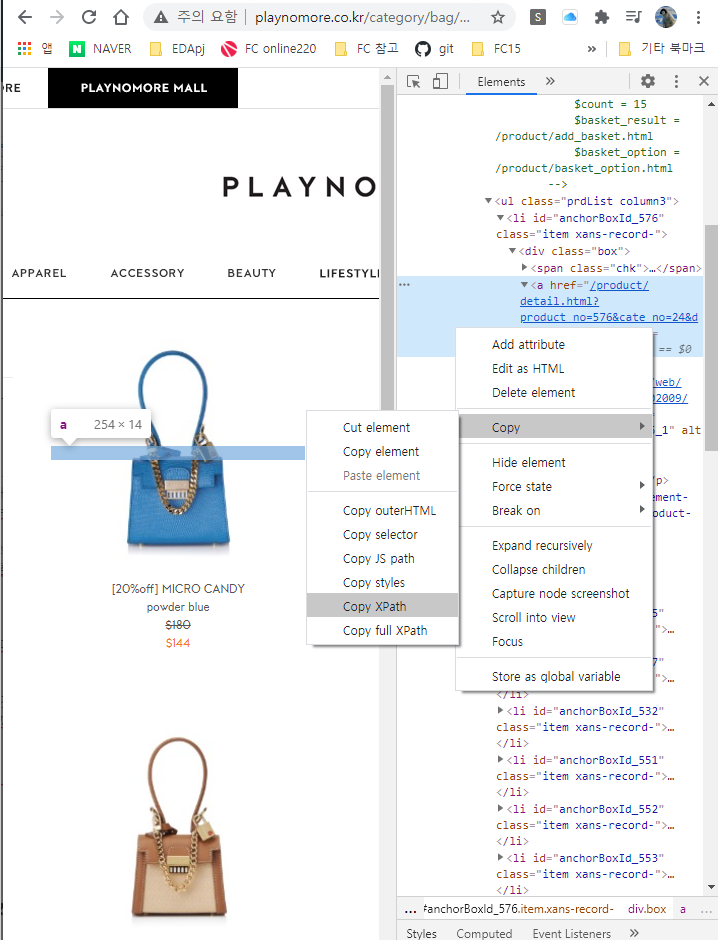  

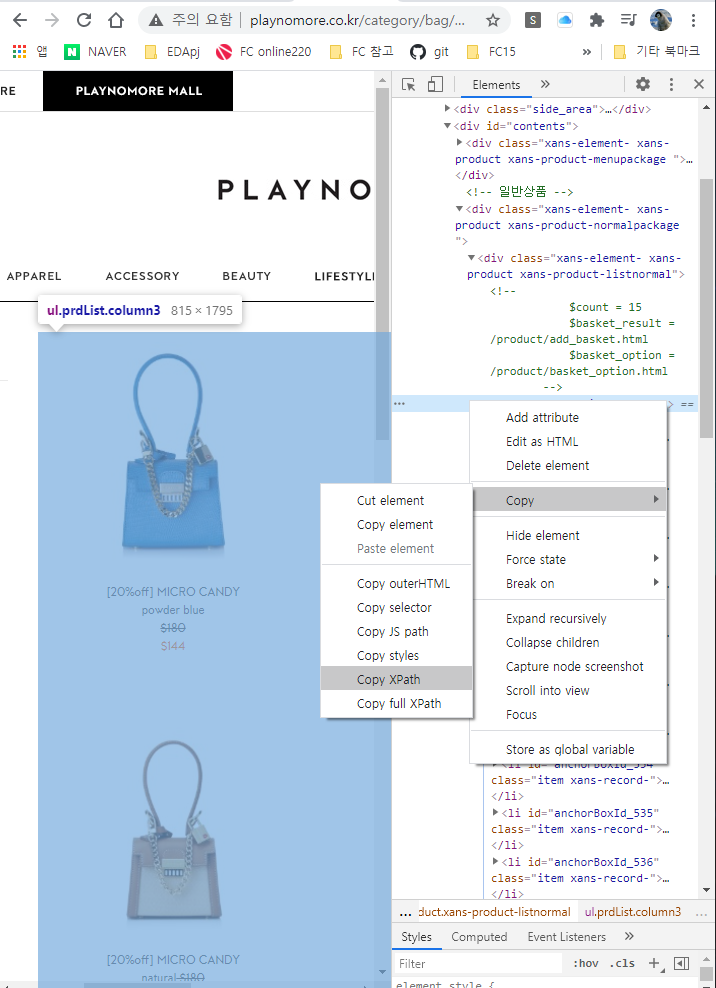  

In [6]:
# 링크
links = response.xpath('//*[@id="contents"]/div[2]/div/ul/li/div/a/@href').extract()
links = list(map(response.urljoin, links))
# response.urljoin(links[0])

In [7]:
# 상세페이지 : 제목, 가격, 이미지URL
url = links[0]
headers = { "User-Agent": UserAgent().chrome }
req = requests.get(url, headers=headers)
response = TextResponse(req.url, body=req.text, encoding="utf-8")
title = response.xpath('//*[@id="contents"]/div[2]/div/ul/li/div/a/@href').extract()

In [8]:
title1 = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[1]/font/text()').extract()
title2 = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[1]/text()').extract()
title = "".join(title1) + "".join(title2)
price = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[2]/text()').extract()[0]
img = "http:" + response.xpath('//*[@id="contents"]/div[1]/div[1]/div[1]/div[1]/img/@src').extract()[0]
title, price, img

('[20%off] MICRO CANDY powder blue ',
 '$ 144',
 'http://playnomore.co.kr/web/product/big/202009/12907438676be914e95868f166c0cdfd.jpg')

### 4. spider.py
- scrapy-fake-useragent 설치
    - `$ pip install scrapy-fake-useragent`

In [9]:
!pip list | grep fake
# 0이 붙으면 정식버전이 아님. 

fake-useragent        0.1.11   
scrapy-fake-useragent 1.4.4    
You are using pip version 18.1, however version 20.3b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
%%writefile playnomore/playnomore/spiders/spider.py
import scrapy
from playnomore.items import PlaynomoreItem

class PlaynomoreSpider(scrapy.Spider):
    name = "Playnomore"
    custom_settings = {
        'DOWNLOADER_MIDDLEWARES': {
            'scrapy.downloadermiddlewares.useragent.UserAgentMiddleware': None,
            'scrapy_fake_useragent.middleware.RandomUserAgentMiddleware': 400,
        }
    }
    
    def __init__(self, category1="bag", category2=24):
        self.start_url = "http://playnomore.co.kr/category/{}/{}/".format(catergory1, category2)
        super().__init__(**kwargs)
        
    def start_requests(self):
        url = "http://playnomore.co.kr/category/bag/24/"
        yield scrapy.Request(url, callback=self.parse)
        
    def parse(self, response):
        links = response.xpath('//*[@id="contents"]/div[2]/div/ul/li/div/a/@href').extract()
        links = list(map(response.urljoin, links))
        for link in links:
            yield scrapy.Request(link, callback=self.page_parse)
    
    def page_parse(self, response):
        item = PlaynomoreItem()
        title1 = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[1]/font/text()').extract()
        title2 = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[1]/text()').extract()
        item["title"] = "".join(title1) + "".join(title2)
        item["price"] = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[2]/text()').extract()[0]
        item["img"] = "http:" + response.xpath('//*[@id="contents"]/div[1]/div[1]/div[1]/div[1]/img/@src').extract()[0]
        item["link"] = response.url
        yield item

Writing playnomore/playnomore/spiders/spider.py


In [11]:
%%writefile run.sh
cd playnomore
scrapy crawl Playnomore -o playnomore.csv -a category1=shoes -a category2=25

Overwriting run.sh


In [12]:
!./run.sh

2020-11-10 16:58:24 [scrapy.utils.log] INFO: Scrapy 2.4.0 started (bot: playnomore)
2020-11-10 16:58:24 [scrapy.utils.log] INFO: Versions: lxml 4.6.1.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.6.9 (default, Oct 19 2020, 01:13:33) - [GCC 7.5.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1h  22 Sep 2020), cryptography 3.2.1, Platform Linux-5.4.0-1029-aws-x86_64-with-debian-buster-sid
2020-11-10 16:58:24 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2020-11-10 16:58:24 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'playnomore',
 'NEWSPIDER_MODULE': 'playnomore.spiders',
 'ROBOTSTXT_OBEY': True,
 'SPIDER_MODULES': ['playnomore.spiders']}
2020-11-10 16:58:24 [scrapy.extensions.telnet] INFO: Telnet Password: ffacacef8439263b
2020-11-10 16:58:24 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUs

In [13]:
import pandas as pd
df = pd.read_csv("playnomore/playnomore.csv")
df.tail(1)

FileNotFoundError: [Errno 2] File b'playnomore/playnomore.csv' does not exist: b'playnomore/playnomore.csv'

### 6. Mongodb에 저장
- 데이터베이스에 저장하기~
- pymongo를 pipelines.py에 적용

In [ ]:
!pip list | grep pymongo

In [ ]:
import pymongo

In [ ]:
client = pymongo.MongoClient('mongodb://52.78.16.7:27017')
client

In [ ]:
db = client.playnomore
collection = db.shoes
collection

In [ ]:
data = {"title":"신발"}
collection.insert(data)

In [14]:
########## scrapy_playnomore_Flask1_nginx 설정_20191128_02  35:00 ######